<a href="https://colab.research.google.com/github/caseyh4/irish_property_analysis/blob/main/Cleaning_Analysis_Prediction_models_with_pyspark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.functions import pandas_udf
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, udf
from pyspark.sql.types import DoubleType
spark = SparkSession.builder.getOrCreate()
from pyspark.sql.types import StructType, StructField, StringType, IntegerType
from pyspark.sql.functions import when, col 

In [ ]:
df = pd.read_csv("../content/myHome_from_page_1_till_page_790_by_20.csv")
if "Unnamed: 0" in df.columns:
  df.drop(columns=["Unnamed: 0"], inplace=True)
df.head(2)

,beds,baths,floor_area,Price,Address,Property_type,New_build,Page
0,3.0,3.0,NaN,PoA,"3 Bedroom Apartment - 55 Lad Lane, Dublin 2",Apartment,NaN,1.0
1,3.0,1.0,105m 2,550000,"38 The Avenue, Boden Park, Rathfarnham, Dubli...",Semi-Detached House,NaN,1.0


In [ ]:
df1 = pd.read_csv("../content/daft_from_page_0_till_page_987_by_20.csv")
if "Unnamed: 0" in df1.columns:
  df1.drop(columns=["Unnamed: 0"], inplace=True)
df1.head(2)

,Bed,Bath,m²,Price,Address,Property_type,New_build,Page
0,2.0,1.0,52.0,295000,"8 Parknasilla, Vevay Road, Bray, Co. Wicklow",Apartment,no,0
1,3.0,3.0,93.0,230000,"7 Meadow Avenue, The Meadows, Hollyhill, Co. Cork",Semi-D,no,0


**Functions for cleaning**

In [ ]:
def fix_price(price):
    try:
        return int(price)
    except ValueError:
        return np.nan
        
def fix_floor_area(area):
    ft2m = 10.764
    median_area = 110
    try:
        if len(area.split()) == 2:
            if area.split()[0][-1] == "m":
                return area.split()[0][:-1]
            elif area.split()[0][-2:] == "ft":
                return round((float(area[:-4])/ft2m),2)
            count += 1
        else:
            area1 = float(area.split(" - ")[0])
            area2 = float(area.split(" - ")[1][:-3])
            
            if np.abs(median_area - area1) <= np.abs(median_area - area2):
                return area1
            else:
                return area2
    except AttributeError:
        pass

df["floor_area"] = df["floor_area"].apply(lambda x :fix_floor_area(x))
    
def find_county(address: str, counties: np.ndarray, county_position=-1) -> str:

    """
    The address is comma seperated with the county at the end. (Some adresses are missing the county).
    We use the array counties to check if the county found is actually a county.
    We also need to check for counties such as Dublin 1, Dublin 2 etc.
    """
    try:
        countyName = address.split(",")[county_position].split()
    except IndexError:
        return np.nan
    if len(countyName) == 1:
        if countyName[0].strip().capitalize() in counties or countyName[0].strip().capitalize()[:-1] in counties:
            return countyName[0].capitalize()
        
        elif len(countyName[0].strip().lower().split("co.")) > 1:
            return countyName[0][3:].capitalize()
        
        else:
            return np.nan
        
    elif len(countyName) == 2:
        if countyName[0].strip().capitalize() in counties or countyName[0].strip().capitalize()[:-1] in counties:
            try:
                int(countyName[1].strip())
                return " ".join(countyName)
            
            except ValueError:
                return countyName[0].strip().capitalize()
            
        elif countyName[1].strip().capitalize() in counties or countyName[1].strip().capitalize()[:-1] in counties:
            return countyName[1].strip().capitalize()
        
        else:
            return np.nan
        
    else:
        for value in countyName:
            if value.strip().capitalize() in counties or value.strip().capitalize()[:-1] in counties:
                return value
            
def fix_counties(county):
    try:
        if county[-1] == "." or county[-1] == "-":
            return county[:-1]
        else:
            return county
    except TypeError:
        return np.nan 
    
def find_province(county: str, county_dict: dict) -> str:

    """"
    This function aims to find the province using the county found with the last function.
    It takes the county in and dictionary to return the correct province.
    """

    if county is None:
        return ""
    elif isinstance(county, float):
        return ""
    elif county in county_dict: # Works for Counties outside of Dublin
        return county_dict[county]
    elif county.split(" ")[0] == "Dublin": # Works for Dublin
        return county_dict["Dublin"]
    else:
        print(f"County: {county} was not found in dictionary")

def create_county_dict(df: pd.DataFrame) -> dict:

    """
    Takes in dataframe with the columns County and Province,
    then returns a dictionary with the county as the key and the province as the value.
    This dictionary is used in the function above.
    """

    county_dict = {}
    for i in range(len(df)):
        county_dict[df["County"][i]] = df["Province"][i]
    return county_dict

**MyHome to Spark Dataframe**

In [ ]:

schema = StructType([
    StructField("beds", DoubleType(), True),
    StructField("baths", DoubleType(), True),
    StructField("floor_area", StringType(), True),
    StructField("Price", StringType(), True),
    StructField("Address", StringType(), True),
    StructField("Property_type", StringType(), True),
    StructField("New_build", StringType(), True),
    StructField("Page", DoubleType(), True),
])

myhome = spark.createDataFrame(df, schema=schema)
myhome.show()

+----+-----+----------+-------+--------------------+-------------------+---------+----+
|beds|baths|floor_area|  Price|             Address|      Property_type|New_build|Page|
+----+-----+----------+-------+--------------------+-------------------+---------+----+
| 3.0|  3.0|      null|    PoA| 3 Bedroom Apartm...|          Apartment|      NaN| 1.0|
| 3.0|  1.0|       105| 550000| 38 The Avenue, B...|Semi-Detached House|      NaN| 1.0|
| 4.0|  3.0|       110| 795000| 130 Carysfort Pa...|Semi-Detached House|      NaN| 1.0|
| 2.0|  1.0|        68| 295000| 5 Woodbrook Hall...|          Apartment|      NaN| 1.0|
| 4.0|  2.0|    170.07| 895000| 70 Kincora Grove...|Semi-Detached House|      NaN| 1.0|
| 4.0|  5.0|       179| 750000| Innishannon, Cov...|     Detached House|      NaN| 1.0|
| 4.0|  3.0|    128.21| 330000| 1 Carlisle Garde...|     Detached House|      NaN| 1.0|
| 3.0|  2.0|       107| 310000| Chapel Court, Sk...|Semi-Detached House|      NaN| 1.0|
| 5.0|  5.0|       520|3950000| 

In [ ]:
myhome.groupBy("Property_type").count().show(500)

+-------------------+-----+
|      Property_type|count|
+-------------------+-----+
|          Apartment| 1375|
|             Dormer|   12|
|          Townhouse|   88|
|               Farm|   51|
|             Studio|    3|
|   Industrial Units|    1|
|          Penthouse|   11|
|      Country House|   37|
|       Holiday Home|    1|
|                End|  463|
|     Live-Work Unit|    5|
|            Cottage|  109|
|              House|  335|
|                NaN|  213|
|     Detached House| 2415|
|       Period House|   18|
|         Investment|   27|
|     Terraced House| 1401|
|           Bungalow|  505|
|             Duplex|  114|
|               Site|  298|
|Semi-Detached House| 2526|
|               Mews|    1|
|   Development Land|    1|
+-------------------+-----+



**Daft to Spark Dataframe**

In [ ]:
schema1 = StructType([
    StructField("Bed", DoubleType(), True),
    StructField("Bath", DoubleType(), True),
    StructField("m²", DoubleType(), True),
    StructField("Price", StringType(), True),
    StructField("Address", StringType(), True),
    StructField("Property_type", StringType(), True),
    StructField("New_build", StringType(), True),
    StructField("Page", StringType(), True),
])

daft = spark.createDataFrame(df1, schema=schema1)
daft.show()

+---+----+------------------+--------------------+--------------------+--------------+---------+----+
|Bed|Bath|                m²|               Price|             Address| Property_type|New_build|Page|
+---+----+------------------+--------------------+--------------------+--------------+---------+----+
|2.0| 1.0|              52.0|              295000|8 Parknasilla, Ve...|     Apartment|       no|   0|
|3.0| 3.0|              93.0|              230000|7 Meadow Avenue, ...|        Semi-D|       no|   0|
|4.0| 3.0|              86.0|              265000|5 Friar Street, C...|       Terrace|       no|   0|
|3.0| 1.0|              82.0|              375000|12 Barrack Street...|End of Terrace|       no|   0|
|5.0| 4.0|             186.0|              405000|3 The Garden, Whi...|        Semi-D|       no|   0|
|6.0| 7.0|             763.0|             3000000|7 Henrietta Stree...|       Terrace|       no|   0|
|5.0| 5.0|             328.0|              795000|Zion House, Carnm...|      Detac

In [ ]:
daft.groupBy("Property_type").count().show(500)

+--------------+-----+
| Property_type|count|
+--------------+-----+
|     Apartment| 2088|
|     Townhouse|  248|
|        Studio|    3|
|End of Terrace|  933|
|        Semi-D| 3988|
|      Detached| 6035|
|       Terrace| 2357|
|      Bungalow|  876|
|        Duplex|  224|
|          Site| 3080|
|         House|    1|
|           NaN|   12|
+--------------+-----+



**Daft Cleaning**

In [ ]:
province_df = pd.read_csv("../content/county_data.csv")
county_dict = create_county_dict(province_df)

In [ ]:
fix_price_udf = udf(lambda x: fix_price(x))
daft = daft.withColumn('Price', fix_price_udf('Price'))
find_county_udf = udf(lambda x: find_county(x, province_df["County"].values))
daft = daft.withColumn('County', find_county_udf('Address'))
find_province_udf = udf(lambda x: find_province(x, county_dict))
daft = daft.withColumn('Province', find_province_udf('County'))
daft = daft.withColumn("Bed", when(col("Bed") == "NaN", 0).otherwise(col("Bed")))
daft = daft.withColumn("Bath", when(col("Bath") == "NaN", 0).otherwise(col("Bath")))
daft.show()

+---+----+------------------+--------+--------------------+--------------+---------+----+---------+---------+
|Bed|Bath|                m²|   Price|             Address| Property_type|New_build|Page|   County| Province|
+---+----+------------------+--------+--------------------+--------------+---------+----+---------+---------+
|2.0| 1.0|              52.0|  295000|8 Parknasilla, Ve...|     Apartment|       no|   0|  Wicklow| Leinster|
|3.0| 3.0|              93.0|  230000|7 Meadow Avenue, ...|        Semi-D|       no|   0|     Cork|  Munster|
|4.0| 3.0|              86.0|  265000|5 Friar Street, C...|       Terrace|       no|   0|     Cork|  Munster|
|3.0| 1.0|              82.0|  375000|12 Barrack Street...|End of Terrace|       no|   0|     Cork|  Munster|
|5.0| 4.0|             186.0|  405000|3 The Garden, Whi...|        Semi-D|       no|   0|    Meath| Leinster|
|6.0| 7.0|             763.0| 3000000|7 Henrietta Stree...|       Terrace|       no|   0| Dublin 1| Leinster|
|5.0| 5.0|

**MyHome Cleaning**

In [ ]:
myhome.show()

+----+-----+----------+-------+--------------------+-------------------+---------+----+
|beds|baths|floor_area|  Price|             Address|      Property_type|New_build|Page|
+----+-----+----------+-------+--------------------+-------------------+---------+----+
| 3.0|  3.0|      null|    PoA| 3 Bedroom Apartm...|          Apartment|      NaN| 1.0|
| 3.0|  1.0|       105| 550000| 38 The Avenue, B...|Semi-Detached House|      NaN| 1.0|
| 4.0|  3.0|       110| 795000| 130 Carysfort Pa...|Semi-Detached House|      NaN| 1.0|
| 2.0|  1.0|        68| 295000| 5 Woodbrook Hall...|          Apartment|      NaN| 1.0|
| 4.0|  2.0|    170.07| 895000| 70 Kincora Grove...|Semi-Detached House|      NaN| 1.0|
| 4.0|  5.0|       179| 750000| Innishannon, Cov...|     Detached House|      NaN| 1.0|
| 4.0|  3.0|    128.21| 330000| 1 Carlisle Garde...|     Detached House|      NaN| 1.0|
| 3.0|  2.0|       107| 310000| Chapel Court, Sk...|Semi-Detached House|      NaN| 1.0|
| 5.0|  5.0|       520|3950000| 

In [ ]:
myhome = myhome.withColumn('Price', fix_price_udf('Price'))
myhome = myhome.withColumn('County', find_county_udf('Address'))
fix_counties_udf = udf(lambda x: fix_counties(x))
myhome = myhome.withColumn('County', fix_counties_udf('County'))
myhome = myhome.withColumn('Province', find_province_udf('County'))
myhome.show()

+----+-----+----------+-------+--------------------+-------------------+---------+----+---------+---------+
|beds|baths|floor_area|  Price|             Address|      Property_type|New_build|Page|   County| Province|
+----+-----+----------+-------+--------------------+-------------------+---------+----+---------+---------+
| 3.0|  3.0|      null|    NaN| 3 Bedroom Apartm...|          Apartment|      NaN| 1.0| Dublin 2| Leinster|
| 3.0|  1.0|       105| 550000| 38 The Avenue, B...|Semi-Detached House|      NaN| 1.0|Dublin 14| Leinster|
| 4.0|  3.0|       110| 795000| 130 Carysfort Pa...|Semi-Detached House|      NaN| 1.0|   Dublin| Leinster|
| 2.0|  1.0|        68| 295000| 5 Woodbrook Hall...|          Apartment|      NaN| 1.0|Dublin 15| Leinster|
| 4.0|  2.0|    170.07| 895000| 70 Kincora Grove...|Semi-Detached House|      NaN| 1.0| Dublin 3| Leinster|
| 4.0|  5.0|       179| 750000| Innishannon, Cov...|     Detached House|      NaN| 1.0|Waterford|  Munster|
| 4.0|  3.0|    128.21| 3300

In [ ]:
myhome = myhome.withColumnRenamed("beds", "Bed")
myhome = myhome.withColumnRenamed("baths", "Bath")
myhome = myhome.withColumnRenamed("floor_area", "m²")

In [ ]:
myhome = myhome.withColumn("Bed", when(col("Bed") == "NaN", 0).otherwise(col("Bed")))
myhome = myhome.withColumn("Bath", when(col("Bath") == "NaN", 0).otherwise(col("Bath")))
myhome.show()


+---+----+------+-------+--------------------+-------------------+---------+----+---------+---------+
|Bed|Bath|    m²|  Price|             Address|      Property_type|New_build|Page|   County| Province|
+---+----+------+-------+--------------------+-------------------+---------+----+---------+---------+
|3.0| 3.0|  null|    NaN| 3 Bedroom Apartm...|          Apartment|      NaN| 1.0| Dublin 2| Leinster|
|3.0| 1.0|   105| 550000| 38 The Avenue, B...|Semi-Detached House|      NaN| 1.0|Dublin 14| Leinster|
|4.0| 3.0|   110| 795000| 130 Carysfort Pa...|Semi-Detached House|      NaN| 1.0|   Dublin| Leinster|
|2.0| 1.0|    68| 295000| 5 Woodbrook Hall...|          Apartment|      NaN| 1.0|Dublin 15| Leinster|
|4.0| 2.0|170.07| 895000| 70 Kincora Grove...|Semi-Detached House|      NaN| 1.0| Dublin 3| Leinster|
|4.0| 5.0|   179| 750000| Innishannon, Cov...|     Detached House|      NaN| 1.0|Waterford|  Munster|
|4.0| 3.0|128.21| 330000| 1 Carlisle Garde...|     Detached House|      NaN| 1.0| 

**Sold property and price change data and analysis**

In [ ]:
df2 = pd.read_csv("/content/myHome_sold_property_from_page_1_till_page_1000.csv", index_col=["Unnamed: 0"])
df3 = pd.read_csv("/content/myHome_price_change_from_page_1_till_page_349.csv", index_col=["Unnamed: 0"])

In [ ]:
sold_df_counties_1 = pd.DataFrame(df2["Address"].apply(lambda x : find_county(x, county_dict,county_position=-1)).dropna())
sold_df_counties_2 = pd.DataFrame(df2["Address"].apply(lambda x : find_county(x, county_dict,county_position=-2)).dropna())
sold_df = df2.join(sold_df_counties_1.append(sold_df_counties_2).sort_index().rename(columns={"Address":"County"})).drop_duplicates(subset="Address")
    
sold_df["County"]= sold_df["County"].replace({"Mayor":"Dublin 1"})
sold_df["Province"] = sold_df["County"].apply(lambda x: find_province(x, county_dict))

In [ ]:
price_change_df_counties_1 = pd.DataFrame(df3["Address"].apply(lambda x : find_county(x, county_dict,county_position=-1)).dropna())
price_change_df_counties_2 = pd.DataFrame(df3["Address"].apply(lambda x : find_county(x, county_dict,county_position=-2)).dropna())
price_change_df = df3.join(price_change_df_counties_1.append(price_change_df_counties_2).sort_index().rename(columns={"Address":"County"})).drop_duplicates(subset="Address")
price_change_df["County"] = price_change_df["County"].apply(lambda x: fix_counties(x))
price_change_df["County"]= price_change_df["County"].replace({"Downs":"Wicklow"})
price_change_df["Province"] = price_change_df["County"].apply(lambda x: find_province(x, county_dict))

In [ ]:
schemax = StructType([
    StructField("Date", StringType(), True),
    StructField("Address", StringType(), True),
    StructField("Price", IntegerType(), True),
    StructField("Page", IntegerType(), True),
    StructField("County", StringType(), True),
    StructField("Province", StringType(), True),
])

sold = spark.createDataFrame(sold_df, schema=schemax)
sold.show()

+----------+--------------------+-------+----+---------+--------+
|      Date|             Address|  Price|Page|   County|Province|
+----------+--------------------+-------+----+---------+--------+
|2022-11-18|ELMFIELD, BARNDAR...| 605000|   1|  Wicklow|Leinster|
|2022-11-18|13 TARA COURT, DU...| 132500|   1|   Dublin|Leinster|
|2022-11-18|23 Brennanstown W...| 837004|   1|Dublin 18|Leinster|
|2022-11-17|MINDORAN, DONEGAL...|  96000|   1|  Donegal|  Ulster|
|2022-11-17|3 Chapel Lane, Ki...| 312775|   1|  Kildare|Leinster|
|2022-11-17|34 HAYFIELD, STRA...| 445000|   1|  Kildare|Leinster|
|2022-11-17|GLENPAUDEEN, ANNA...| 175000|   1|Tipperary| Munster|
|2022-11-17|24 Sessile Oaks, ...| 334857|   1|  Wicklow|Leinster|
|2022-11-17|7 Stonebridge Lan...| 594714|   1|Dublin 18|Leinster|
|2022-11-16|708 THE VILLAGE, ...| 510000|   1|  Kildare|Leinster|
|2022-11-16|8 RATHWOOD, BLACK...| 378855|   1|  Kildare|Leinster|
|2022-11-16|HAGGARD, KILDARE,...| 225000|   1|  Kildare|Leinster|
|2022-11-1

In [ ]:
schemay = StructType([
    StructField("Date", StringType(), True),
    StructField("Address", StringType(), True),
    StructField("New_price", IntegerType(), True),
    StructField("Old_price", IntegerType(), True),
    StructField("Change(€)", IntegerType(), True),
    StructField("Change(%)", DoubleType(), True),
    StructField("Page", IntegerType(), True),
    StructField("County", StringType(), True),
    StructField("Province", StringType(), True),
])

price = spark.createDataFrame(price_change_df, schema=schemay)
price.show()

+----------+--------------------+---------+---------+---------+---------+----+---------+---------+
|      Date|             Address|New_price|Old_price|Change(€)|Change(%)|Page|   County| Province|
+----------+--------------------+---------+---------+---------+---------+----+---------+---------+
|2022-11-26| 5 Woodbrook Hall...|   295000|   275000|    20000|     7.27|   1|Dublin 15| Leinster|
|2022-11-25| 18 The Crescent,...|   379950|   369950|    10000|      2.7|   1|  Kildare| Leinster|
|2022-11-25| 9 Hawthorn House...|   430000|   399950|    30050|     7.51|   1|Dublin 18| Leinster|
|2022-11-25| Ballybricken, Gr...|    99000|   100000|    -1000|     -1.0|   1| Limerick|  Munster|
|2022-11-25| 5 Woodstown Rise...|   505000|   530000|   -25000|    -4.72|   1|Dublin 16| Leinster|
|2022-11-25| Weatherfort,Clog...|    55000|    65000|   -10000|   -15.38|   1|     Mayo|Connaught|
|2022-11-25| 23 Oakwood, Old ...|   300000|   275000|    25000|     9.09|   1| Limerick|  Munster|
|2022-11-2

**Highest Priced Property Sold**

In [ ]:
from pyspark.sql.functions import desc, col, asc

dfeo = sold.select(['Address', 'Price'])

# Sort the DataFrame by price in descending order
dfeo = dfeo.sort(desc('Price'))

# Get the first row (which should have the highest price)
row = dfeo.first()

# Print the address, property category, and price
print("Address:", row['Address'])
print("Price:", row['Price'])

Address: Apartments 1 - 297, Blackwood Square, Northwood
Price: 109055078


**Cheapest Property sold**

In [ ]:
dfeof = sold.select(['Address', 'Price'])

# Sort the DataFrame by price in descending order
dfeof = dfeof.sort(asc('Price'))

# Get the first row (which should have the highest price)
row = dfeof.first()

# Print the address, property category, and price
print("Address:", row['Address'])
print("Price:", row['Price'])

Address: Mooretown, Smarmore, Drogheda, Co. Louth
Price: 5500


**Highest increase in price**



In [ ]:
dfeod = price.select(['Address', 'New_price', 'Change(%)'])

# Sort the DataFrame by price in descending order
dfeod = dfeod.sort(desc('Change(%)'))

# Get the first row (which should have the highest price)
row = dfeod.first()

# Print the address, property category, and price
print("Address:", row['Address'])
print("New_price:", row['New_price'])
print("Change(%):", row['Change(%)'])

Address:  "Lissadell House", Curragha Road, Ratoath, Meath 
New_price: 975000
Change(%): 69.57


**Joining the myhome and daft dataframes**

In [ ]:
daft = daft.drop("New_build")
myhome = myhome.drop("New_build")
daft = daft.drop("Page")
myhome = myhome.drop("Page")

In [ ]:
daft_pandas = daft.toPandas()
daft_pandas

,Bed,Bath,m²,Price,Address,Property_type,County,Province
0,2.0,1.0,52.0,295000,"8 Parknasilla, Vevay Road, Bray, Co. Wicklow",Apartment,Wicklow,Leinster
1,3.0,3.0,93.0,230000,"7 Meadow Avenue, The Meadows, Hollyhill, Co. Cork",Semi-D,Cork,Munster
2,4.0,3.0,86.0,265000,"5 Friar Street, Cork City, Co. Cork",Terrace,Cork,Munster
3,3.0,1.0,82.0,375000,"12 Barrack Street, Kinsale, Co. Cork",End of Terrace,Cork,Munster
4,5.0,4.0,186.0,405000,"3 The Garden, Whitefield Manor, Bettystown, Co...",Semi-D,Meath,Leinster
...,...,...,...,...,...,...,...,...
19840,4.0,3.0,128.0,NaN,"The Oak - 4 Bed Semi-Detached, Cluain Dara, Cl...",NaN,Kildare,Leinster
19841,3.0,3.0,105.0,365000,"House Type D, Castle Rock, Castle Rock, Castle...",Semi-D,Limerick,Munster
19842,1.0,1.0,58.0,260000,"Elder / Ash, Hillfort, Hillfort , Kill, Co. K...",NaN,Kildare,Leinster
19843,3.0,3.0,103.0,425000,"Elm, Hillfort, Hillfort , Kill, Co. Kildare",NaN,Kildare,Leinster


In [ ]:
myhome_pandas = myhome.toPandas()
myhome_pandas['m²'] = myhome_pandas['m²'].fillna('NaN')
myhome_pandas


,Bed,Bath,m²,Price,Address,Property_type,County,Province
0,3.0,3.0,NaN,NaN,"3 Bedroom Apartment - 55 Lad Lane, Dublin 2",Apartment,Dublin 2,Leinster
1,3.0,1.0,105,550000,"38 The Avenue, Boden Park, Rathfarnham, Dubli...",Semi-Detached House,Dublin 14,Leinster
2,4.0,3.0,110,795000,"130 Carysfort Park, Blackrock, County Dublin",Semi-Detached House,Dublin,Leinster
3,2.0,1.0,68,295000,"5 Woodbrook Hall, Carpenterstown, Dublin 15",Apartment,Dublin 15,Leinster
4,4.0,2.0,170.07,895000,"70 Kincora Grove, Clontarf, Dublin 3",Semi-Detached House,Dublin 3,Leinster
...,...,...,...,...,...,...,...,...
10005,5.0,5.0,200,365000,"No. 1 Gleann Na Boirne, Bellharbour, Clare",Detached House,Clare,Munster
10006,3.0,1.0,107,419000,"Knockdilly Cottage, Knockdilly, Kilmuckridge,...",Detached House,Wexford,Leinster
10007,4.0,3.0,248.51,435000,"Dooneen, Carrigtwohill, Cork",Detached House,Cork,Munster
10008,2.0,3.0,75,197500,"14 Blossom Court, Esker Hills, Portlaoise, Laois",Detached House,Laois,Leinster


In [ ]:
all_data = pd.concat([daft_pandas, myhome_pandas])

# Use the drop_duplicates method to remove duplicates
all_data = all_data.drop_duplicates()
all_data = all_data.reset_index(drop=True)
all_data

,Bed,Bath,m²,Price,Address,Property_type,County,Province
0,2.0,1.0,52.0,295000,"8 Parknasilla, Vevay Road, Bray, Co. Wicklow",Apartment,Wicklow,Leinster
1,3.0,3.0,93.0,230000,"7 Meadow Avenue, The Meadows, Hollyhill, Co. Cork",Semi-D,Cork,Munster
2,4.0,3.0,86.0,265000,"5 Friar Street, Cork City, Co. Cork",Terrace,Cork,Munster
3,3.0,1.0,82.0,375000,"12 Barrack Street, Kinsale, Co. Cork",End of Terrace,Cork,Munster
4,5.0,4.0,186.0,405000,"3 The Garden, Whitefield Manor, Bettystown, Co...",Semi-D,Meath,Leinster
...,...,...,...,...,...,...,...,...
29648,5.0,5.0,200,365000,"No. 1 Gleann Na Boirne, Bellharbour, Clare",Detached House,Clare,Munster
29649,3.0,1.0,107,419000,"Knockdilly Cottage, Knockdilly, Kilmuckridge,...",Detached House,Wexford,Leinster
29650,4.0,3.0,248.51,435000,"Dooneen, Carrigtwohill, Cork",Detached House,Cork,Munster
29651,2.0,3.0,75,197500,"14 Blossom Court, Esker Hills, Portlaoise, Laois",Detached House,Laois,Leinster


**Converting back to spark data frame**

In [ ]:
schemaQ = StructType([
    StructField("Bed", DoubleType(), True),
    StructField("Bath", DoubleType(), True),
    StructField("m²", StringType(), True),
    StructField("Price", StringType(), True),
    StructField("Address", StringType(), True),
    StructField("Property_type", StringType(), True),
    StructField("County", StringType(), True),
    StructField("Province", StringType(), True),
])

all = spark.createDataFrame(all_data, schema=schemaQ)
all.show()

+---+----+------------------+--------+--------------------+--------------+---------+---------+
|Bed|Bath|                m²|   Price|             Address| Property_type|   County| Province|
+---+----+------------------+--------+--------------------+--------------+---------+---------+
|2.0| 1.0|              52.0|  295000|8 Parknasilla, Ve...|     Apartment|  Wicklow| Leinster|
|3.0| 3.0|              93.0|  230000|7 Meadow Avenue, ...|        Semi-D|     Cork|  Munster|
|4.0| 3.0|              86.0|  265000|5 Friar Street, C...|       Terrace|     Cork|  Munster|
|3.0| 1.0|              82.0|  375000|12 Barrack Street...|End of Terrace|     Cork|  Munster|
|5.0| 4.0|             186.0|  405000|3 The Garden, Whi...|        Semi-D|    Meath| Leinster|
|6.0| 7.0|             763.0| 3000000|7 Henrietta Stree...|       Terrace| Dublin 1| Leinster|
|5.0| 5.0|             328.0|  795000|Zion House, Carnm...|      Detached|   Galway|Connaught|
|5.0| 4.0|             232.0|  625000|3 The Fairwa

**Creating Property Category**

In [ ]:
property_types = all.select("Property_type").distinct().collect()

# Convert the list of Row objects to a list of strings
property_types = [row['Property_type'] for row in property_types]

print(property_types)

['Apartment', 'Townhouse', 'Studio', 'End of Terrace', 'Semi-D', 'Detached', 'House', 'Terrace', 'Bungalow', 'Duplex', 'Site', 'Dormer', 'Farm', 'Industrial Units', 'Penthouse', 'Country House', 'Holiday Home', 'End', 'Live-Work Unit', 'Mews', 'Cottage', 'NaN', 'Detached House', 'Period House', 'Investment', 'Terraced House', 'Development Land', 'Semi-Detached House']


In [ ]:
from pyspark.sql.functions import udf, when

# Define the mapping of property types to property categories
property_type_to_category_mapping = {
  'Apartment': 'Apartment', 'Townhouse': 'House', 'Studio': 'Studio', 'End of Terrace': 'House', 'Semi-D': 'House', 
 'Detached': 'House', 'House': 'House', 'Terrace': 'House', 'Bungalow': 'House', 'Duplex': 'House', 'Site': 'Site', 'Dormer': 'House', 
 'Farm': 'Farm', 'Industrial Units': 'Industrial Units', 'Penthouse': 'House', 'Country House': 'House', 'Holiday Home': 'House', 
 'End': 'House', 'Live-Work Unit': "Studio", 'Mews': 'House', 'Cottage': 'House', 'NaN': 'NaN', 'Detached House': 'House', 'Period House': 'House', 
 'Investment': "Investment", 'Terraced House': 'House', 'Development Land': 'Land', 'Semi-Detached House': 'House'
 }

# Define the UDF that maps property types to property categories
def map_property_type_to_category(property_type):
    return property_type_to_category_mapping.get(property_type)

map_property_type_to_category_udf = udf(map_property_type_to_category)

# Convert the property types to property categories
all = all.withColumn("Property Category", map_property_type_to_category_udf(col("Property_type")))

# Replace the null values in the "Property Category" column with "other"
all = all.withColumn("Property Category", when(col("Property Category").isNull(), "other").otherwise(col("Property Category")))
all.show()


+---+----+------------------+--------+--------------------+--------------+---------+---------+-----------------+
|Bed|Bath|                m²|   Price|             Address| Property_type|   County| Province|Property Category|
+---+----+------------------+--------+--------------------+--------------+---------+---------+-----------------+
|2.0| 1.0|              52.0|  295000|8 Parknasilla, Ve...|     Apartment|  Wicklow| Leinster|        Apartment|
|3.0| 3.0|              93.0|  230000|7 Meadow Avenue, ...|        Semi-D|     Cork|  Munster|            House|
|4.0| 3.0|              86.0|  265000|5 Friar Street, C...|       Terrace|     Cork|  Munster|            House|
|3.0| 1.0|              82.0|  375000|12 Barrack Street...|End of Terrace|     Cork|  Munster|            House|
|5.0| 4.0|             186.0|  405000|3 The Garden, Whi...|        Semi-D|    Meath| Leinster|            House|
|6.0| 7.0|             763.0| 3000000|7 Henrietta Stree...|       Terrace| Dublin 1| Leinster|  

**Analysis on property listings**

In [ ]:
analysis = all.toPandas()
analysis = analysis.drop(columns=["Property_type"])
analysis = analysis.dropna()
analysis = analysis[~analysis['m²'].str.contains("N|A")]
analysis = analysis[~analysis['Price'].str.contains("N|A")]
analysis = analysis[~analysis['Address'].str.contains("N|A")]
analysis = analysis[~analysis['County'].str.contains("N|A")]
analysis = analysis[~analysis['Province'].str.contains("N|A")]
analysis= analysis[~analysis['Property Category'].str.contains("N|A")]

#Back to Spark Data Frame
schemaQ = StructType([
    StructField("Bed", DoubleType(), True),
    StructField("Bath", DoubleType(), True),
    StructField("m²", StringType(), True),
    StructField("Price", StringType(), True),
    StructField("Address", StringType(), True),
    StructField("County", StringType(), True),
    StructField("Province", StringType(), True),
    StructField("Property Category", StringType(), True),   
])

aa = spark.createDataFrame(analysis, schema=schemaQ)
aa.show()

+---+----+-----+--------+--------------------+---------+---------+-----------------+
|Bed|Bath|   m²|   Price|             Address|   County| Province|Property Category|
+---+----+-----+--------+--------------------+---------+---------+-----------------+
|4.0| 3.0| 86.0|  265000|5 Friar Street, C...|     Cork|  Munster|            House|
|3.0| 1.0| 82.0|  375000|12 Barrack Street...|     Cork|  Munster|            House|
|5.0| 4.0|186.0|  405000|3 The Garden, Whi...|    Meath| Leinster|            House|
|6.0| 7.0|763.0| 3000000|7 Henrietta Stree...| Dublin 1| Leinster|            House|
|5.0| 5.0|328.0|  795000|Zion House, Carnm...|   Galway|Connaught|            House|
|5.0| 4.0|232.0|  625000|3 The Fairways, M...|     Cork|  Munster|            House|
|3.0| 2.0|171.0|  230000|Derryart, Dunfana...|  Donegal|   Ulster|            House|
|4.0| 3.0|125.0|  295000|168 Palace Fields...|   Galway|Connaught|            House|
|5.0| 5.0|781.0|10000000|Drumleck House, C...|Dublin 13| Leinster

**Highest Property Price**

In [ ]:
from pyspark.sql.functions import desc, col

# Select the address, property category, and price columns
dfe = aa.select(['Address', 'Property Category', 'Price'])

# Sort the DataFrame by price in descending order
dfe = dfe.sort(desc('Price'))

# Get the first row (which should have the highest price)
row = dfe.first()

# Print the address, property category, and price
print("Address:", row['Address'])
print("Property Category:", row['Property Category'])
print("Price:", row['Price'])


Address: Development Site, Mullagh, Co. Cavan
Property Category: Site
Price: 999995


**Most Expensive House**

In [ ]:
from pyspark.sql.functions import desc, col


# Filter the DataFrame to only include rows where the property category is "house"
dft = aa.filter(col('Property Category') == 'House')

# Select the address, property category, and price columns
dft = dft.select(['Address', 'Property Category', 'Price'])

# Sort the DataFrame by price in descending order
dft = dft.sort(desc('Price'))

# Get the first row (which should have the highest price)
row = dft.first()

# Print the address, property category, and price
print("Address:", row['Address'])
print("Property Category:", row['Property Category'])
print("Price:", row['Price'])


Address: Former Bank, Main Street, Cloughjordan, Co. Tipperary
Property Category: House
Price: 99950


**Average Price in each county**

In [ ]:
from pyspark.sql.functions import avg

# Group the DataFrame by county and compute the average price for each group
dfh = aa.groupBy('County').agg(avg('Price').alias('avg_price'))

# Sort the DataFrame by average price in descending order
dfh = dfh.sort(desc('avg_price'))
dfh.show()

+---------+------------------+
|   County|         avg_price|
+---------+------------------+
| Dublin 4|1327955.4187192118|
| Dublin 6|1254651.3043478262|
| Dublin 2|         1170000.0|
|Dublin 18| 959623.3333333334|
|Dublin 13| 941432.2115384615|
| Dublin 1|        849059.375|
|Dublin 14| 787316.4583333334|
|   Dublin| 762292.0584045585|
|Dublin 06|          725000.0|
|  Wicklow| 603921.3787085515|
| Dublin 3|  595933.448275862|
|Dublin 16| 587903.4246575342|
| Dublin 9| 516583.0459770115|
| Dublin 8|496605.51181102364|
| Dublin 5| 494794.1176470588|
|Dublin 15| 474825.8823529412|
| Dublin 7|462234.14634146343|
|    Meath| 454272.5201072386|
|  Kildare| 452863.3507853403|
|Dublin 20|422020.93023255817|
+---------+------------------+
only showing top 20 rows



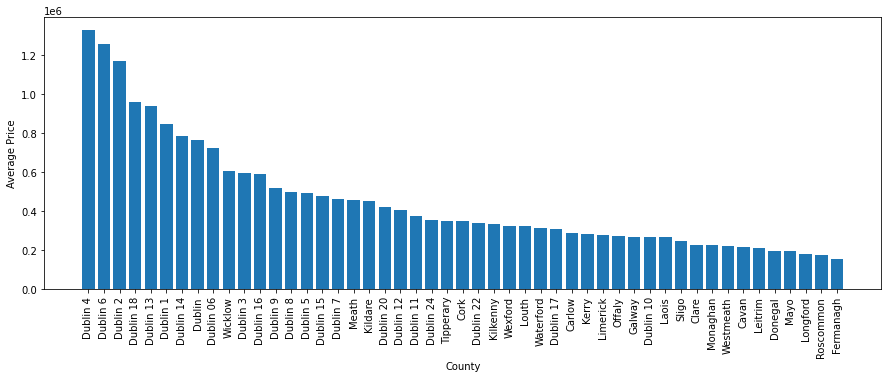

In [ ]:
import matplotlib.pyplot as plt

# Extract the county and average price columns as a NumPy array
counties = dfh.select('County').toPandas().values
avg_prices = dfh.select('avg_price').toPandas().values

# Flatten the arrays to extract the values
counties = counties.flatten()
avg_prices = avg_prices.flatten()
# Create a bar chart of the average price in each county
plt.figure(figsize=(15, 5))
plt.bar(counties, avg_prices)
plt.xlabel('County')
plt.ylabel('Average Price')

# Rotate the labels on the x-axis by 90 degrees
plt.xticks(rotation=90)

plt.show()

**Price Prediction Models**

In [ ]:
pred = all.toPandas()
pred = pred.drop(columns=["Property_type"])
pred = pred.dropna()
pred = pred[~pred['m²'].str.contains("N|A")]
pred = pred[~pred['Price'].str.contains("N|A")]
pred = pred[~pred['Address'].str.contains("N|A")]
pred = pred[~pred['County'].str.contains("N|A")]
pred = pred[~pred['Province'].str.contains("N|A")]
pred = pred[~pred['Property Category'].str.contains("N|A")]
pred

,Bed,Bath,m²,Price,Address,County,Province,Property Category
2,4.0,3.0,86.0,265000,"5 Friar Street, Cork City, Co. Cork",Cork,Munster,House
3,3.0,1.0,82.0,375000,"12 Barrack Street, Kinsale, Co. Cork",Cork,Munster,House
4,5.0,4.0,186.0,405000,"3 The Garden, Whitefield Manor, Bettystown, Co...",Meath,Leinster,House
5,6.0,7.0,763.0,3000000,"7 Henrietta Street, Dublin 1",Dublin 1,Leinster,House
6,5.0,5.0,328.0,795000,"Zion House, Carnmore West, Carnmore, Co. Galway",Galway,Connaught,House
...,...,...,...,...,...,...,...,...
29642,4.0,1.0,81.7,245000,"9 Cloonlara Cresent, Finglas, Dublin 11",Dublin 11,Leinster,House
29646,3.0,1.0,100,159000,"14 Knockbarry Cottages, Buttevant, Cork",Cork,Munster,House
29649,3.0,1.0,107,419000,"Knockdilly Cottage, Knockdilly, Kilmuckridge,...",Wexford,Leinster,House
29650,4.0,3.0,248.51,435000,"Dooneen, Carrigtwohill, Cork",Cork,Munster,House


In [ ]:
pred.replace([np.inf, -np.inf], np.nan)

,Bed,Bath,m²,Price,Address,County,Province,Property Category
2,4.0,3.0,86.0,265000,"5 Friar Street, Cork City, Co. Cork",Cork,Munster,House
3,3.0,1.0,82.0,375000,"12 Barrack Street, Kinsale, Co. Cork",Cork,Munster,House
4,5.0,4.0,186.0,405000,"3 The Garden, Whitefield Manor, Bettystown, Co...",Meath,Leinster,House
5,6.0,7.0,763.0,3000000,"7 Henrietta Street, Dublin 1",Dublin 1,Leinster,House
6,5.0,5.0,328.0,795000,"Zion House, Carnmore West, Carnmore, Co. Galway",Galway,Connaught,House
...,...,...,...,...,...,...,...,...
29642,4.0,1.0,81.7,245000,"9 Cloonlara Cresent, Finglas, Dublin 11",Dublin 11,Leinster,House
29646,3.0,1.0,100,159000,"14 Knockbarry Cottages, Buttevant, Cork",Cork,Munster,House
29649,3.0,1.0,107,419000,"Knockdilly Cottage, Knockdilly, Kilmuckridge,...",Wexford,Leinster,House
29650,4.0,3.0,248.51,435000,"Dooneen, Carrigtwohill, Cork",Cork,Munster,House


In [ ]:
pred.isnull().sum()

Bed                  0
Bath                 0
m²                   0
Price                0
Address              0
County               0
Province             0
Property Category    0
dtype: int64

**Linear Regression**

In [ ]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split


# Select the columns to use as features
X = pred[['Bed', 'Bath', 'm²', 'County', 'Property Category']]

# Encode categorical variables as numerical data
X = pd.get_dummies(X)

# Select the target variable
y = pred['Price']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a SimpleImputer to replace missing values with the mean
imputer = SimpleImputer(strategy='mean')

# Fit the imputer on the training data
imputer.fit(X_train)

# Transform the training and test data
X_train = imputer.transform(X_train)
X_test = imputer.transform(X_test)

# Create a linear regression model
model = LinearRegression()

# Train the model on the training data
model.fit(X_train, y_train)

# Evaluate the model on the test data
score = model.score(X_test, y_test)

# Print the R^2 score of the model
print("R^2 score: {:.2f}".format(score))


R^2 score: -7936272344442915840.00


**Random Forest**

In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split



# Select the columns to use as features
X = pred[['Bed', 'Bath', 'm²', 'County', 'Property Category']]

# Encode categorical variables as numerical data
X = pd.get_dummies(X)

# Select the target variable
y = pred['Price']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a SimpleImputer to replace missing values with the mean
imputer = SimpleImputer(strategy='median')

# Fit the imputer on the training data
imputer.fit(X_train)

# Transform the training and test data
X_train = imputer.transform(X_train)
X_test = imputer.transform(X_test)

# Create a random forest regressor
model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model on the training data
model.fit(X_train, y_train)

# Evaluate the model on the test data
score = model.score(X_test, y_test)

# Print the R^2 score of the model
print("R^2 score: {:.2f}".format(score))


R^2 score: 0.34


**Gradient Booster**

In [ ]:
import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score

# Select the features to use for the prediction
X = pred[['Bed', 'Bath', 'm²', 'County', 'Property Category']]
# Encode categorical variables as numerical data
X = pd.get_dummies(X)
# Select the target variable
y = pred['Price']

# Create a gradient boosted model
gbr = GradientBoostingRegressor()

# Fit the model to the training data
gbr.fit(X, y)

# Make predictions on the test data
y_pred = gbr.predict(X_test)

# Calculate the R^2 score
r2 = r2_score(y_test, y_pred)
print("R^2 score:", r2)

R^2 score: 0.761325802861248


/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
